# Локализация. Упражнения

В этих упражнениях вам предлагается реализовать простые алгоритмы локализации роботов. На лекции, помимо фильтра частиц, были упомянуты методы триангуляции и альфа-бета фильтр. Давайте их реализуем: обе реализации должны быть сделаны в виде класса, у которого должен быть метод update. Метод update принимает на вход измеренения с камеры о положении ориентиров в сосбтвенной системе координат робота.

В качестве ориентиров будем использовать координаты стоек ворот. Для удобства будем пользоваться упрощенным вариантом, при котором ворота разных цветов. В словаре храняться положения стоек в глобальной системе координат (точка (0, 0) нахождится в центре поля)

In [4]:
import random
import json
import numpy as np
import matplotlib.pylab as plt
import math

In [5]:
class Field:
    def __init__(self, path):
        with open(path, "r") as f:
            self.field = json.loads(f.read())
            self.w_width = self.field['main_rectangle'][0][0]
            self.w_length = self.field['main_rectangle'][0][1]

class Robot:
    def __init__(self, x=0, y=0, yaw=0):
        self.x = x          # robot's x coordinate
        self.y = y          # robot's y coordinate
        self.yaw = yaw      # robot's angle

    def set_coord(self, new_x, new_y, new_orientation):
        self.x = float(new_x)
        self.y = float(new_y)
        self.yaw = float(new_orientation)

    def move(self, x, y, yaw):
        # turn, and add randomomness to the turning command
        orientation = self.yaw + float(yaw)
        if orientation < 0:
            orientation += (math.pi*2)
        orientation %= (2 * math.pi)
        self.x += x*math.cos(self.yaw)
        self.y += y*math.sin(self.yaw)
        self.yaw = orientation

In [6]:
landmarks = {
    "blue_posts": [
        [ -4.5, -1.0], [ -4.5, 1.0]
    ],
    "yellow_posts":[
        [ 4.5, -1.0], [ 4.5, 1.0]
    ]
}

Пример данных, которые могут поступать в модуль на одном шаге всей системы. Данные во втором словаре – это данные одометрии с собвственной информацией робота о перемещении за один шаг системы. Для проверки работы придумайте и запишите набор данных с такой же структурой. 

In [17]:
observations = {"yellow_posts":[[2.0, -1.0],[2.0, 1.0]], "blue_posts":[]}
shift = {'shift_x':0.0, 'shift_y':0.01, 'shift_angle':-0.4}

### 1) Реализовать локализацию триангуляцией (3 балл)
    

In [29]:
class localization_triangulation:
    def __init__(self, myrobot, field, landmarks):
        self.myrobot = myrobot
        self.field   = field
        self.landmarks = landmarks
        
    def update(self, observations):
        for color_landmark in observations:
            if (color_landmark not in self.landmarks):
                continue

            if len(observations[color_landmark]) != 0:
                print(observations[color_landmark][0][0])
                r1 = math.sqrt(observations[color_landmark][0][0]**2 + observations[color_landmark][0][1]**2)
                r2 = math.sqrt(observations[color_landmark][1][0]**2 + observations[color_landmark][1][1]**2)
                self.myrobot.y = (r1**2 - r2**2) / 4

                x1 = math.sqrt(r1**2 - (self.myrobot.y - self.landmarks[color_landmark][0][1])**2) + self.landmarks[color_landmark][0][0]
                x2 = -math.sqrt(r1**2 - (self.myrobot.y - self.landmarks[color_landmark][0][1])**2) + self.landmarks[color_landmark][0][0]
                if abs(x1) > self.field.w_length / 2:
                    self.myrobot.x = x2
                else:
                    self.myrobot.x = x1
        

### 2) Дополнить предыдущий пункт до альфа-бета фильтра (5 балла)

In [30]:
class localization_alphabeta(localization_triangulation):
    def __init__(self, myrobot, field, landmarks, alpha, betha):
        super(localization_alphabeta, self).__init__(myrobot, field, landmarks)

        self.alpha = alpha
        self.betha = betha

    def update(self, observations, shift):
        x_od = self.myrobot.x + shift["shift_x"]
        y_od = self.myrobot.y + shift["shift_y"]
        self.myrobot.yaw += shift["shift_angle"]

        super(localization_alphabeta, self).update(observations)

        self.myrobot.x = self.myrobot.x * self.alpha + x_od * self.betha
        self.myrobot.y = self.myrobot.y * self.alpha + y_od * self.betha


        

### 3) *Дополнительно* Добавьте визуализацию вида сверху  (2 балла)

Например на OpenCV или Matplotlib, например так как было в семинаре, чтобы можно было удобно посмотреть на работу модуля.


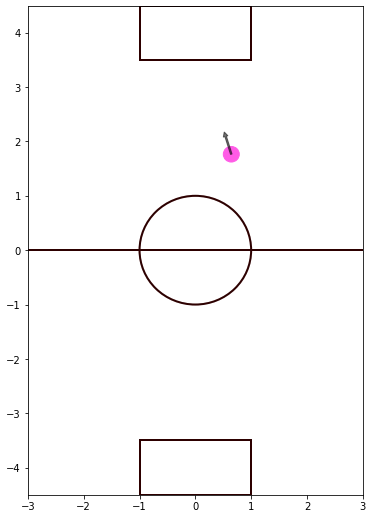

In [10]:
field = Field('parfield.json')

def visualization(robot, factor = 7 ):
    
    plt.figure("Robot in the world",figsize=(field.w_width, field.w_length))
    plt.title('Particle filter')
 
    # draw coordinate grid for plotting
    grid = [-field.w_width/2.0, field.w_width/2.0, -field.w_length/2.0, field.w_length/2.0]
    ax = plt.axis(grid)
    
    landmarks = {
    "blue_posts": [
        [ -1.0, -4.5], [ 1.0, -4.5]
    ],
    "yellow_posts":[[ -1.0, 4.5], [1.0, 4.5]]}
    
    for el in field.field:
        if el == 'circles':
            for circle in field.field['circles']:
                plot_circle = plt.Circle((circle[0], circle[1]), circle[2],linewidth=2, fill=False, edgecolor='#330000')
                plt.gca().add_patch(plot_circle)
        if el == 'lines' :     
            for line in field.field['lines']:
                plot_line = plt.Line2D(line[0], line[1], linewidth=2, linestyle="-", color='#330000')
                plt.gca().add_line(plot_line)
        if el == 'rectangles' :     
            for rectangle in field.field['rectangles']:
                rect = plt.Rectangle(rectangle[0], rectangle[1], rectangle[2], linewidth=2, linestyle="-", fill = False, edgecolor='#330000')
                plt.gca().add_patch(rect)
 
    # robot's location
    circle = plt.Circle((robot.y, robot.x), 1./factor, facecolor='#FF66E9', edgecolor='#FF66E9')
    plt.gca().add_patch(circle)
 
    # robot's orientation
    arrow = plt.Arrow(robot.y, robot.x, 3*math.sin(robot.yaw)/factor, 3*math.cos(robot.yaw)/factor, width=1.0/factor, alpha=0.5, facecolor='#000000', edgecolor='#000000')
    plt.gca().add_patch(arrow)


    #fixed landmarks of known locations2
   
    for lm in landmarks:
        for lms in landmarks[lm]:
            if lm == "yellow_posts":
                circle = plt.Circle(((lms[0], lms[1])), 
                                1./factor, facecolor = '#ffff00', edgecolor='#330000')
                plt.gca().add_patch(circle)
            else:
                circle = plt.Circle(((lms[0], lms[1])), 
                                1./factor, facecolor =  '#060C73', edgecolor='#330000')
                plt.gca().add_patch(circle)
    
 
    #plt.close()

## Тестируем

2.0
2.0


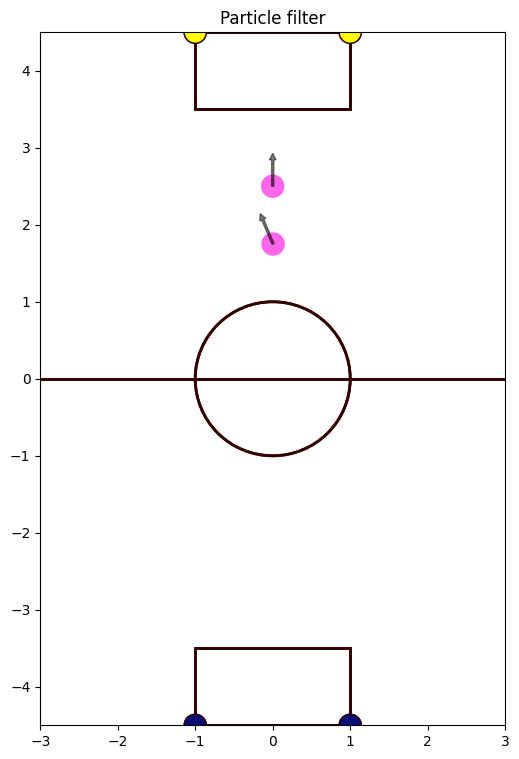

In [32]:
observations = {"yellow_posts":[[2.0, -1.0],[2.0, 1.0]], "blue_posts":[]}
shift = {'shift_x':1.0, 'shift_y':0.01, 'shift_angle':-0.4}

lt = localization_triangulation(Robot(0.0, 0.0, 0.0), field, landmarks)

lt.update(observations)

visualization(lt.myrobot, factor = 7 )

lab = localization_alphabeta(Robot(0.0, 0.0, 0.0), field, landmarks, 0.5, 0.5)

lab.update(observations, shift)

visualization(lab.myrobot, factor = 7 )

In [34]:
!git status
!git add localization_hw8.ipynb
!git commit -m "Added hw8"
!fir push origin

Текущая ветка: main
Эта ветка соответствует «origin/main».

Изменения, которые не в индексе для коммита:
  (используйте «git add <файл>...», чтобы добавить файл в индекс)
  (используйте «git restore <файл>...», чтобы отменить изменения в рабочем каталоге)
	изменено:      cv_hw1.ipynb
	изменено:      cv_hw3.ipynb
	изменено:      cv_hw4.ipynb
	изменено:      github_hw1.ipynb
	изменено:      github_sem1.ipynb
	изменено:      localization_hw8.ipynb
	изменено:      nn_sem5_pt2_hw5.ipynb

Неотслеживаемые файлы:
  (используйте «git add <файл>...», чтобы добавить в то, что будет включено в коммит)
	../data/imgs/3.mov
	../data/ref.jpg
	../data/vid.mp4
	parfield.json

индекс пуст (используйте «git add» и/или «git commit -a»)
[main 4013911] Added hw8
 1 file changed, 213 insertions(+), 27 deletions(-)
zsh:1: command not found: fir
